# Notebook Instructions
<i>You can run the notebook document sequentially (one cell at a time) by pressing <b> shift + enter</b>. While a cell is running, a [*] will display on the left. When it has been run, a number will display indicating the order in which it was run in the notebook [8].</i>

<i>Enter edit mode by pressing <b>`Enter`</b> or using the mouse to click on a cell's editor area. Edit mode is indicated by a green cell border and a prompt showing in the editor area.</i> <BR>
    
This course is based on specific versions of python packages. You can find the details of the same in <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank" >this manual</a>. The manual also explains how to use these codes in other versions of python packages. <BR>

# Comparison: Regime Change Detection Methods
In this notebook, we will compare all the three regime methods, namely moving average crossover, breakout-breakdown and floor ceiling. <BR>

We will compare these methods on the following parameters:
1. Regime change signals
2. Cumulative returns
3. Drawdowns


## Import libraries

In [1]:
# Data manipulation libraries
import numpy as np
import pandas as pd
from datetime import datetime

# Calculates swing highs and lows
from scipy.signal import *
from scipy.signal import argrelextrema

# Appends new file paths to import modules
import sys
sys.path.append("..")

# All functions library
from data_modules.short_selling import swings
from data_modules.short_selling import regime_breakout_breakdown
from data_modules.short_selling import regime_sma
from data_modules.short_selling import regime_fc
from data_modules.short_selling import returns
from data_modules.short_selling import cumulative_returns

# Imports charting libraries
import matplotlib.pyplot as plt

%matplotlib inline

## Import data


The file `Jan_2010_to_Jan_2019_Rebased_Series.csv` contains the rebased series for 'Bank of America'. This data is available in the last unit of this course. You can find this file in the downloadables section of the course. 

We import these data by using the pandas function 'pandas.read_csv()'.

In [2]:
# Data is stored in the directory 'data_modules' 
relative_path = "../data_modules/"
# Reads and imports the rebased series using the function 'read_csv'
data = pd.read_csv(
    relative_path + 'Jan_2010_to_Jan_2019_Rebased_Series.csv', index_col=0, parse_dates=True)

# Set index in datetime format
data.index = pd.to_datetime(data.index)

# Returns the first two rows of the dataset
data.head(2)

,Open,High,Low,Close,USDGBP,SP500,adjustment_factor,relative_open,relative_high,relative_low,relative_close,rebased_open,rebased_high,rebased_low,rebased_close
Date,,,,,,,,,,,,,,,
2010-01-04,15.24,15.75,15.12,15.69,0.62,113.33,70.35,0.22,0.22,0.21,0.22,15.24,15.75,15.12,15.69
2010-01-05,15.74,16.21,15.70,16.20,0.63,113.63,71.06,0.22,0.23,0.22,0.23,15.58,16.05,15.54,16.04


## Parameter 1: Regime Change

In this method, we use relative series to calculate

1. Regime breakout-breakdown
2. Regime simple moving average
4. Regime floor and ceiling

In [3]:
# 1. Calculate regime breakout using the 'regime_breakout' for a breakout period of 252 days
data = regime_breakout_breakdown(
    breakout_period=252, df=data, high='rebased_high', low='rebased_low')

# 2. Calculate the regime simple moving average using 'regime_sma' function
data = regime_sma(df=data, price='rebased_close', short_term=20, long_term=200)


# 3. Calculate swings using the 'swings' function
argrel_window = 20
data = swings(df=data, high='rebased_high',
              low='rebased_low', argrel_window=argrel_window)

# 4. Using the 'regime_fc' function, calculate the floor and ceiling
data = regime_fc(data, 'rebased_close', 'srebased_low',
                 'srebased_high', threshold=1.5, t_dev=63, decimals=2)

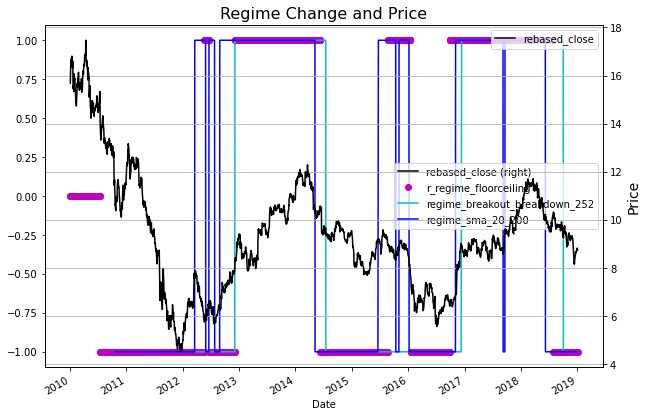

In [4]:
# 5. Plot the regime change
# Here 'r' stands for relative, refer to the code to understand the label
data[['rebased_close', 'r_regime_floorceiling', 'regime_breakout_breakdown_252', 'regime_sma_20_200']].plot(
    style=['k', 'mo', 'c', 'b'],
    secondary_y=['rebased_close'], figsize=(10, 7))

# Add a legend
plt.legend()
# Display the plot
plt.title('Regime Change and Price', fontsize=16)
plt.ylabel('Price', fontsize=14)
plt.xlabel('Date', fontsize=14)
# Add a grid
plt.grid()
# Display the graph
plt.show()

## Parameter 2: Returns

In part 2, we will calculate cumulative returns and plot them along with the passive relative returns. The Floor/Ceiling method has built-in hindsight bias which means swings are discovered and retroactively assigned. We, therefore, need to introduce a lag, which can be lesser than or equal to the argel window.

In [5]:
# 1. Calculate relative and cumulative relative returns for rebased close price
data['relative_returns'] = returns(data['rebased_close'])
data['cum_relative_returns'] = cumulative_returns(data['relative_returns'])

# 2. Calculate relative and cumulative relative returns for regime breakout using the relative returns
data['regime_breakout_breakdown_252_returns'] = data['relative_returns'] * \
    data['regime_breakout_breakdown_252'].shift(1)
data['cum_regime_breakout_breakdown_252_returns'] = cumulative_returns(
    data['regime_breakout_breakdown_252_returns'])

# 3. Calculate relative and cumulative relative returns for moving average using the relative returns
data['regime_sma_returns'] = data['relative_returns'] * \
    data['regime_sma_20_200'].shift(1)
data['cum_regime_sma_20_200_returns'] = cumulative_returns(
    data['regime_sma_returns'])

# 4. Calculate relative and cumulative relative returns for regime floorceiling using the relative returns
# Declare argel_lag
argrel_lag = argrel_window

data['floorceiling_returns'] = data['relative_returns'] * \
    data['r_regime_floorceiling'].shift(argrel_lag)
data['cum_regime_floorceiling_returns'] = cumulative_returns(
    data['floorceiling_returns'])

print('The returns are: ')
returns = (data[['cum_relative_returns', 'cum_regime_floorceiling_returns',
      'cum_regime_breakout_breakdown_252_returns', 'cum_regime_sma_20_200_returns']].iloc[-1]-1)*100
returns

The returns are: 


cum_relative_returns                         -44.231995
cum_regime_floorceiling_returns               53.488779
cum_regime_breakout_breakdown_252_returns     53.248597
cum_regime_sma_20_200_returns                109.961704
Name: 2019-01-02 00:00:00, dtype: float64

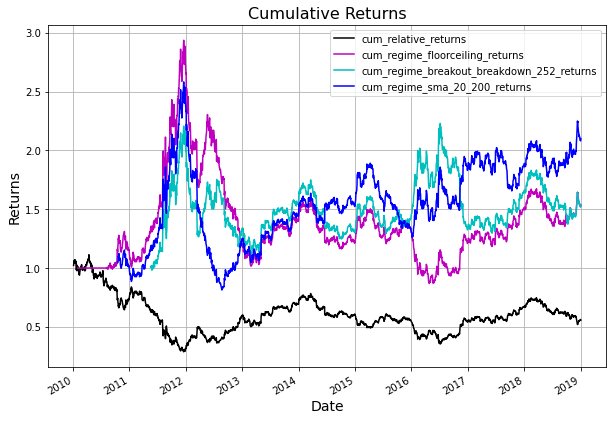

In [6]:
# 5. And, plot all these cumulative returns
data[['cum_relative_returns', 'cum_regime_floorceiling_returns',
      'cum_regime_breakout_breakdown_252_returns', 'cum_regime_sma_20_200_returns']].plot(
    style=['k', 'm', 'c', 'b'], figsize=(10, 7))

plt.title('Cumulative Returns', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Returns', fontsize=14)

# Add a legend
plt.legend()
# Add a grid
plt.grid()
# Display the graph
plt.show()

## Parameter 3: Drawdowns
A drawdown refers to how much an investment or trading account is down from the peak.

In [7]:
def calc_drawdown(cum_rets):
    # Calculate the running maximum
    running_max = np.maximum.accumulate(cum_rets.dropna())
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = (cum_rets)/running_max - 1
    return drawdown

def plot_drawdown(drawdown):
    fig = plt.figure(figsize=(16, 10))
    loc = 1
    for col in drawdown.columns:
        # Add the subplot
        sub = fig.add_subplot(2, 2, loc)
        loc = loc+1
        # Set title
        sub.set_title(col, fontsize=20)
        # Plot
        drawdown[col].plot(color='r')
        sub.set_ylabel('Returns')
        sub.fill_between(drawdown.index, drawdown[col], color='red')
        sub.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
    plt.tight_layout()
    plt.show()

The maximum drawdowns:
cum_relative_returns                        -71.191842
cum_regime_floorceiling_returns             -70.418374
cum_regime_breakout_breakdown_252_returns   -49.094522
cum_regime_sma_20_200_returns               -68.472996
dtype: float64


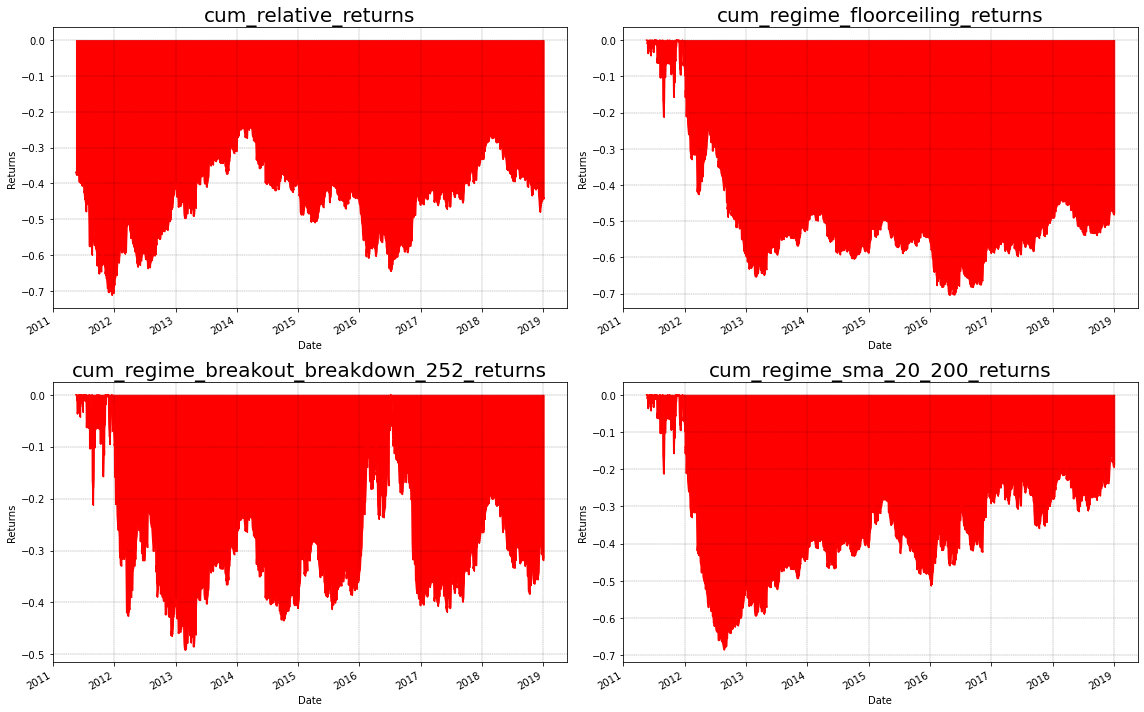

In [8]:
drawdown = calc_drawdown(data[['cum_relative_returns', 'cum_regime_floorceiling_returns',
      'cum_regime_breakout_breakdown_252_returns', 'cum_regime_sma_20_200_returns']])
# Find the maximum drawdowns
print('The maximum drawdowns:')
print(drawdown.min()*100)
#plt.style.use('seaborn-darkgrid')
plot_drawdown(drawdown)

### Conclusion
Bank of America has been in a volatile range bound for many years. The 52 weeks or 252 days breakout method and the floor and ceiling worked as near perfect reverse indicators. The golden cross method seems to have a positive expectancy. 

The golden cross method captures regime changes better than other methods and ultimately delivers better-compounded returns over time. It, however, has a major drawback: Volatility. Everyone wants the returns, but no-one wants the drawdowns. The maximum drawdown in the golden cross method is also high. A better approach looks like combining all these three methods. You can give it a try and see the results. Good luck.
<BR><BR>

In [17]:
def r_sma(price_view, short_term, long_term):
    """
    Brian's implement
    when price >= sma bull +1, when price < sma: bear -1, fillna
    :param price_view: subset of price history, index: date, col=a single price column
    :param short_term:
    :param long_term:
    :return:
    """
    # TODO meta data for all of these columns would be useful to know how/from where
    # TODO they were constructed
    # define rolling high/low
    sma_st = price_view.rolling(window=short_term, min_periods=short_term).mean()
    sma_st.name = 'sma_short'
    sma_lt = price_view.rolling(window=long_term, min_periods=long_term).mean()
    sma_lt.name = 'sma_long'
    price = price_view.copy(deep=True)
    price.name = 'price'

    ma_cross_df = pd.concat([price, sma_st, sma_lt], axis=1)

    # when price>= sma: bull, when price<sma: bear
    ma_cross_df['regime'] = np.where(
        sma_st >= sma_lt,
        1,
        np.where(
            sma_st < sma_lt,
            -1,
            np.nan
        )
    )
    ma_cross_df['regimes'] = ma_cross_df['regime'].fillna(method='ffill')
    return ma_cross_df

res = r_sma(data.rebased_close, 10, 20)
#res.regimes == res.regime

False